# Clip Segmentation
This notebook is about aligning clips from face footages with the corresponding survey answer. Given a list of start and end times of a participant's survey answers, return a list of webcam clips corresponding to these survey answers. Each of these clips will be written in a folder corresponding to the survey answer of that session.

In [1]:
import sys

sys.path.append("../src")

In [2]:
import datetime
import json
import os

import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from moviepy.editor import VideoFileClip
from tqdm.notebook import tqdm

from data_processing.survey import *
from data_processing.video import *
from utils import Paths

In [3]:
paths = Paths("../configs/paths.json")

In [5]:
root = paths["RawWebcam"]
user_folder = os.listdir(root)[0]
user_id = user_folder.split("_")[0]
for f in os.listdir(os.path.join(root, user_folder)):
    if f.endswith("mp4"):
        video_path = os.path.join(root, user_folder, f)
        break

## Loading the footage

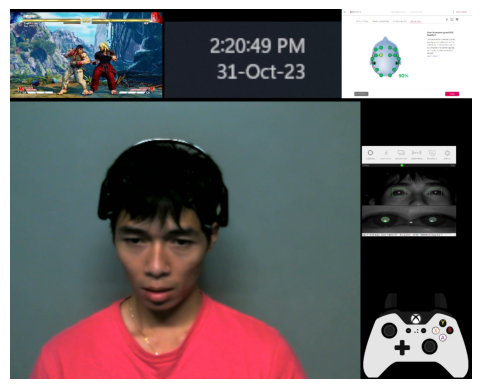

In [6]:
video = VideoFileClip(video_path)
plot_frame(video.get_frame(120))

## Extracting the clip

In [6]:
survey = load_participant_answers(user_id, db_path=paths["SurveyDB"])
survey.head()

,id,user_id,game_id,level_id,session_no,start_ts,end_ts,engagement,interest,stress,excitement
0,471,118,2,7,1,2023-10-31 14:50:07-04:00,2023-10-31 14:50:35-04:00,0,1,0,1
1,472,118,2,7,2,2023-10-31 14:51:06-04:00,2023-10-31 14:51:35-04:00,0,0,0,0
2,473,118,2,7,3,2023-10-31 14:51:57-04:00,2023-10-31 14:52:24-04:00,0,0,0,0
3,474,118,2,8,1,2023-10-31 14:53:17-04:00,2023-10-31 14:53:52-04:00,0,0,1,0
4,475,118,2,8,2,2023-10-31 14:54:09-04:00,2023-10-31 14:54:35-04:00,0,1,0,0


The video filename is expected to be named with the creation date and time of the video. So it corresponds approximately to the Timestamp of the first frame. The videos are captured at 30FPS.

Now using moviepy we need to:
- Extract the clip using the start and end timestamps.
- Crop the clip to keep only ROI (i.e. the webcam footage).
- Reduce the resolution.
- Save whole head clips.

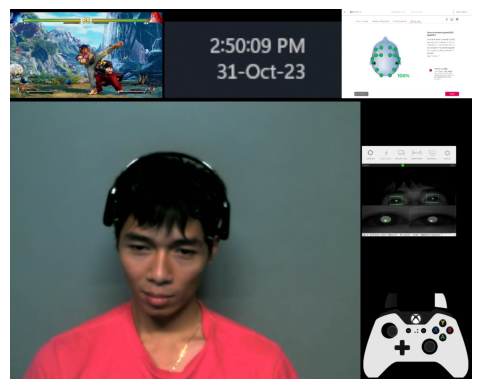

In [7]:
creation_datetime = get_video_creation_datetime(video_path)
clip = extract_clip(video, survey.iloc[0], creation_datetime)
plot_frame(clip.get_frame(0))

## Cropping ROI

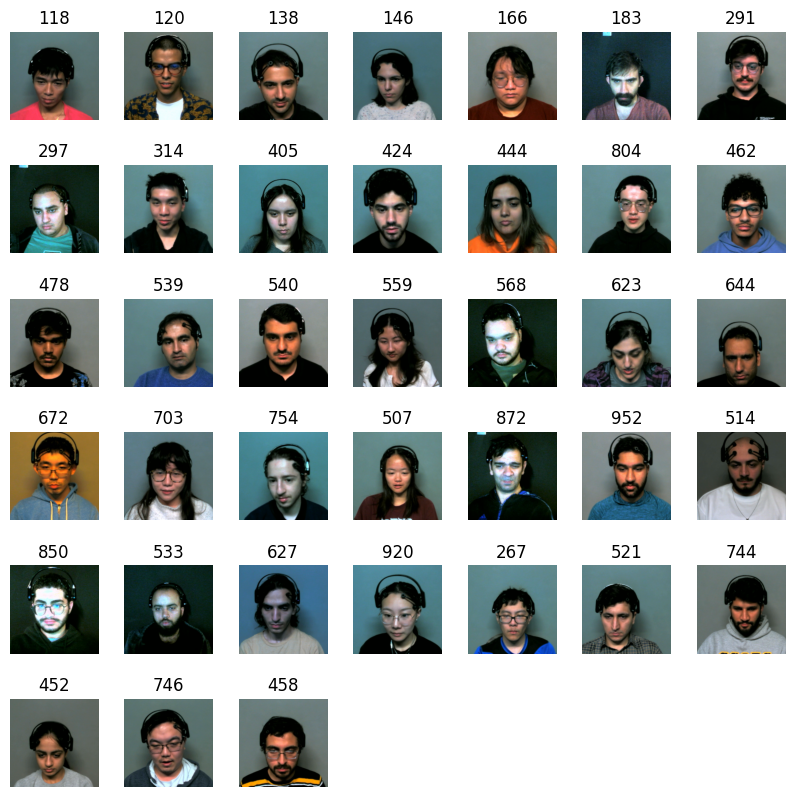

In [8]:
fig, axs = plt.subplots(nrows=6, ncols=7, figsize=(10, 10))
axs = axs.flatten()
i = 0
for p in os.listdir(root):
    user_folder = os.path.join(root, p)
    user_id = int(p.split("_")[0])
    for f in os.listdir(user_folder):
        if not f.endswith("mp4"):
            continue
        video_path = os.path.join(user_folder, f)
        creation_datetime = get_video_creation_datetime(video_path)
        video = VideoFileClip(video_path)
        survey = load_participant_answers(user_id, paths["SurveyDB"])
        clip = extract_clip(video, survey.iloc[0], creation_datetime)
        cropped_clip = crop_square(clip)
        cropped_frame = cropped_clip.get_frame(0)

        axs[i].imshow(cropped_frame)
        axs[i].set_title(str(user_id))
        axs[i].axis("off")
        i += 1
for a in axs[i:]:
    a.set_visible(False)
plt.subplots_adjust(wspace=0.3, hspace=0.3);

In [9]:
cropped_clip.size

(680, 680)

## Reducing the resolution

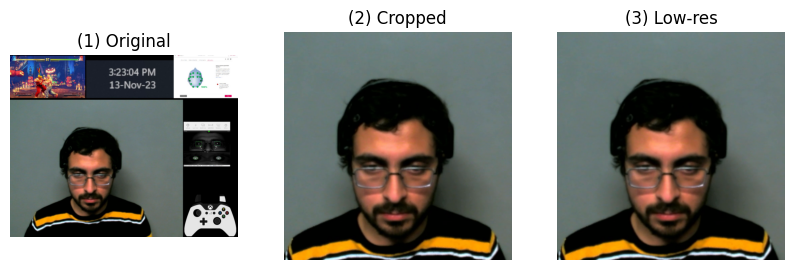

In [10]:
full_frame = clip.get_frame(0)
cropped_frame = cropped_clip.get_frame(0)

low_res_clip = reduce_resolution(cropped_clip)
low_res_frame = low_res_clip.get_frame(0)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(full_frame)
axes[0].set_title("(1) Original")
axes[0].axis("off")

axes[1].imshow(cropped_frame)
axes[1].set_title("(2) Cropped")
axes[1].axis("off")

axes[2].imshow(low_res_frame)
axes[2].set_title("(3) Low-res")
axes[2].axis("off");

## Streamlining the processing scripts

In [11]:
def process_participant(
    path, out_dir, cropping_params=dict(x1=120, x2=800, y1=270, y2=950)
):
    # extract_user_id
    user_id = int(os.path.split(path)[-1].split("_")[0])
    # load survey answers
    sessions_info = load_participant_answers(user_id)
    # video path
    mp4_files = [file for file in os.listdir(path) if file.endswith(".mp4")]
    if len(mp4_files) != 1:
        warnings.warn(f"Incorrect number of videos for user: {user_id}")
        return None

    video_path = os.path.join(path, mp4_files[0])
    data = process_game_sessions(
        video_path, sessions_info, cropping_params=cropping_params
    )
    for session in tqdm(data, desc="Writing videos", leave=False):
        ID = session["ans_id"]
        EN = session["engagement"]
        IN = session["interest"]
        ST = session["stress"]
        EX = session["excitement"]
        target_name = f"{user_id}_{ID}_{EN}_{IN}_{ST}_{EX}.mp4"
        output_folder = os.path.join(out_dir, str(user_id))
        if not os.path.isdir(output_folder):
            os.makedirs(output_folder)
        session["clip"].write_videofile(
            os.path.join(output_folder, target_name),
            verbose=False,
            audio=False,
            logger=None,
        )

In [ ]:
Parallel(n_jobs=-1, backend="threading")(
    delayed(process_participant)(os.path.join(root, p), paths["ProcessedVideos"])
    for p in os.listdir(root)
);

In [ ]:
# This participant was leaning forward, so we need to increase the cropping window
# {"297", "533", "314", "458", "568", "424"}
user = [p for p in os.listdir(root) if p.split("_")[0] == "424"][0]
process_participant(
    os.path.join(root, user),
    paths["ProcessedVideos"],
    cropping_params=dict(x1=120 - 70, x2=800 + 70, y1=270 - 70, y2=950 + 70),
)